# Evaluate Primary Site and Tumor Normal Classifier

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import keras

import matplotlib.pyplot as plt
import seaborn as sns

# fix random seed for reproducibility
np.random.seed(42)

Using TensorFlow backend.


# Load Trained Model and Test Data

In [8]:
# Load the model and predict the test set
model = keras.models.model_from_json(open("models/pancan_gtex.model.json").read())
model.load_weights("models/pancan_gtex.weights.h5")
params = json.loads(open("models/pancan_gtex.params.json").read())

In [15]:
print(sorted(params["hyperparameters"], key=lambda r: r["loss"])[0])

print("Number of genes:", len(params["genes"]))

{'loss': 0.121351882806029, 'params': {'width': 32, 'depth': 2, 'penalty': 0.01, 'batch_size': 64}, 'seconds': 77, 'counter': 161, 'iterations': 27.0, 'num_model_params': 186566}
Number of genes: 5110


In [3]:
%%time
X_all = pd.read_hdf(os.path.expanduser("~/data/pancan_gtex.h5"), "samples")
Y = pd.read_hdf(os.path.expanduser("~/data/pancan_gtex.h5"), "labels")
print("Loaded {} samples with {} features and {} labels".format(X_all.shape[0], X_all.shape[1], Y.shape[1]))

Loaded 17964 samples with 42326 features and 42 labels
CPU times: user 219 ms, sys: 2.15 s, total: 2.36 s
Wall time: 2.36 s


In [4]:
# Convert tumor normal and primary site to numeric values so we can plot confusion and errors againsts them
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index)

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

In [5]:
# Prune so we match the training
X = X_all.drop(labels=(set(X_all.columns) - set(params["genes"])), axis=1)
print("Pruned features down to {} genes".format(X.shape[1]))

X_train = X.values[params["train_indices"]]
Y_train = Y.iloc[params["train_indices"]]

X_test = X.values[params["test_indices"]]
Y_test = Y.iloc[params["test_indices"]]

Pruned features down to 700 genes


In [6]:
# Predict all test samples
predictions = model.predict(X_test)

## Evaluate

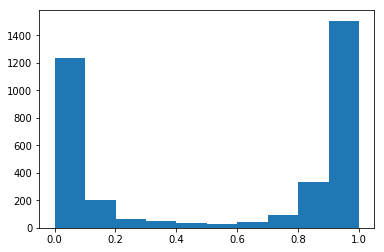

Tumor/Normal Confusion Matrix
[[1560   82]
 [  26 1925]]


In [7]:
# Plot the distribution of tumor/normal values and confusion matrix
plt.hist(predictions[:,0])
plt.show()

from sklearn.metrics import confusion_matrix
print("Tumor/Normal Confusion Matrix")
print(confusion_matrix(Y_test["tumor_normal_value"], np.round(predictions[:,0])))

In [8]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix optionally normalized by class size
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

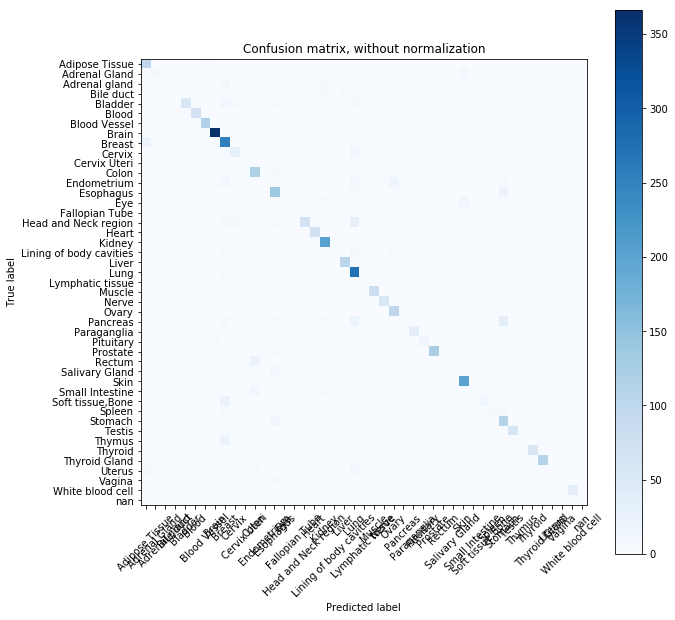

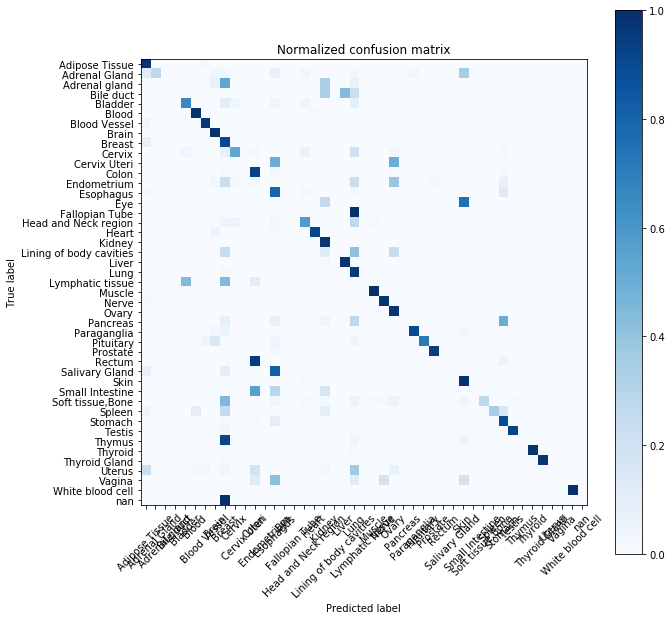

In [9]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    Y_test["primary_site_value"], np.array([np.argmax(p[1:-1]) for p in predictions]))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()